In [28]:
import pandas as pd
import numpy as np
import skimage
from skimage import io, transform, morphology, segmentation, measure
from skimage.io import imread
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# /static/train/Type_1/0.jpg
DIR_BASE = '.'
imgs = glob.glob(os.path.join(DIR_BASE, 'static/train/Type_1/', '*.jpg'))
num_imgs = len(imgs)
print('Number of images of type_1 in train size: {}'.format(num_imgs))



Number of images of type_1 in train size: 1


h0: 3264  w0: 2448
transform resize: (3264, 2448, 3)


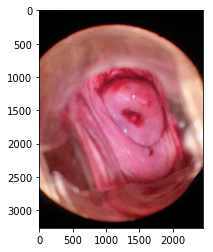

In [23]:
SHORTER_EDGE = 400  # image's shorter edge after resizing
def read_img(img_name):
    img = imread(img_name)
    h0, w0, _ = img.shape
    print("h0:",h0," w0:",w0)
    if h0 >= w0:
        w = SHORTER_EDGE
        h = int(h0/w0*w)
    else:
        h = SHORTER_EDGE
        w = int(w0/h0*h)
    #img = transform.resize(img, (h,w))
    img_lab = skimage.color.rgb2lab(img) # Later the LAB color space will be used.
    print ("transform resize:",img_lab.shape)
    return img, img_lab

img_name = imgs[0]
img, img_lab = read_img(img_name)
plt.imshow(img)

3


(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([  1.25152185e-07,   5.01406335e-02,   1.00281142e-01,
          1.50421650e-01,   2.00562159e-01,   2.50702667e-01,
          3.00843175e-01,   3.50983684e-01,   4.01124192e-01,
          4.51264700e-01,   5.01405209e-01]),
 <a list of 10 Patch objects>)

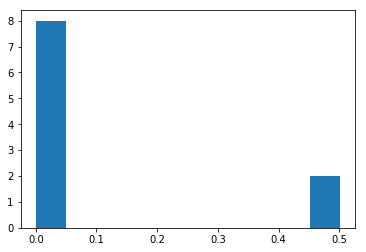

In [29]:
def histo(im, nbin=10 ,xmin=0, xmax=255 ,normalized=True):
    ndim = im.ndim
    print (ndim)
    bins = np.linspace(xmin, xmax, nbin+1)
    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)
    return imhist


plt.hist(histo(img))

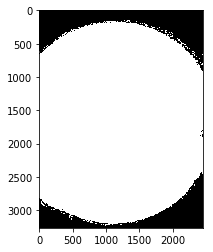

In [24]:
def find_roi_by_gsmix(img, mask=None):
    h,w,_ = img.shape
    x_coor = np.repeat(range(h), w)  # for calculating the R
    y_coor = np.tile(range(w), h)
    if mask is None:
        center = [h/2, w/2]
    else:
        mask = mask.reshape(-1)
        center = [np.mean(x_coor[mask==1]), np.mean(y_coor[mask==1])]
    R = np.sqrt((x_coor-center[0])**2 + (y_coor-center[1])**2)  # R
    A = img_lab[:,:,1].reshape(-1)  # A
    Ra = np.vstack([R, A]).T  # concat R and A

    scaler = MinMaxScaler()
    Ra = scaler.fit_transform(Ra)
    gs_mix = GaussianMixture(n_components=2, random_state=42, init_params='kmeans') # Gaussian mixture modele
    gs_mix.fit(Ra)
    labels = gs_mix.predict(Ra)
    
    # Cluster with lowest R-mean will be chosen as ROI
    means = gs_mix.means_
    if means[0,0] < means[1,0]:
        labels = 1 - labels
    mask = labels.reshape(h, w)

    return mask

roi_mask = find_roi_by_gsmix(img)
plt.imshow(roi_mask, 'gray')

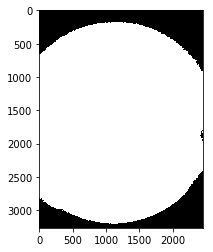

In [25]:
def postprocess_mask(mask, morp=False):    
    
    selem = skimage.morphology.disk(5)
    mask = skimage.morphology.binary_erosion(mask,selem)
    
    labels_mask = measure.label(mask)
    regions = measure.regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    mask = labels_mask
    
    selem = skimage.morphology.disk(5)
    mask = skimage.morphology.binary_dilation(mask,selem)

    if morp:
        selem = skimage.morphology.disk(10)
        mask = skimage.morphology.binary_erosion(mask,selem)
        mask = skimage.morphology.binary_dilation(mask,selem)

    return mask

mask = postprocess_mask(roi_mask, True)
plt.imshow(mask, 'gray')